## Figure upwelled tracer

In [2]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
import matplotlib.patches as pat
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.metrics_tools as mpt
import canyon_tools.savitzky_golay as sg

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [61]:
sns.set_context('paper')
sns.set_style('white')

def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

In [5]:
tracers = ['Tr01','Tr03','Tr04','Tr08','Tr09']
colours = ['#332288','#44AA99','#117733','#999933','#AA4499']
labels_exp = ['Astoria', 'ARGO', 'Barkley', 'Pathways']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['(muM)m3/s','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']

In [6]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'


state_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
state = xr.open_dataset(state_file)
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [7]:
nz = 104
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
    
with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
   

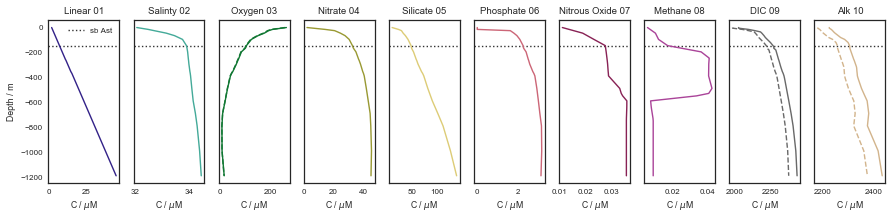

In [8]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileA],[ZA],['-']):
        with Dataset(pfile, 'r') as nbl:
        
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = nbl.variables[trac][0,:,10,180]
                ax[ii].plot(1E-3*tr_profile, Z, color=col,linestyle=style)
                ax[ii].set_xlabel(r'C / $\mu$M')
            
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                tr_profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                ax[ii].plot(density*tr_profile/1000, Z, color=col,linestyle=style)
                ax[ii].plot(tr_profile, Z, color=col,linestyle='--')
                ax[ii].set_xlabel(r'C / $\mu$M')
            
            else:
                ax[ii].set_xlabel(r'C / $\mu$M')
                tr_profile = nbl.variables[trac][0,:,10,180]
                ax[ii].plot(tr_profile, Z, color=col,linestyle=style)

        ax[ii].set_title(lab)
        
        
ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

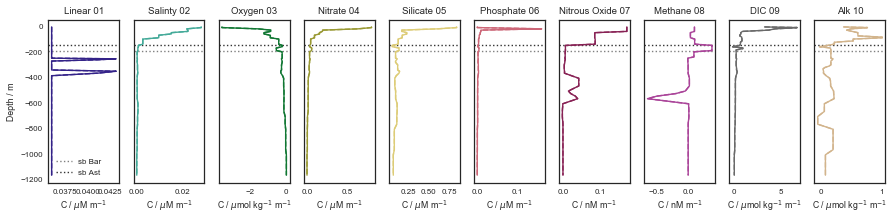

In [9]:
dTr_Ast = np.empty(len(tracers))
dTr_Bar = np.empty(len(tracers))
Tr_Ast = np.empty(len(tracers))
Tr_Bar = np.empty(len(tracers))

fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            dTrdz = (tr_profile[2:]-tr_profile[:-2])/(-Z[2:]+Z[:-2])  
            dTr_Ast[ii] = dTrdz[sb_Ast+1]/dTrdz[sb_Ast-1]
            dTr_Bar[ii] = dTrdz[sb_Bar+1]/dTrdz[sb_Bar-1]
            Tr_Ast[ii] = tr_profile[sb_Ast]
            Tr_Bar[ii] = tr_profile[sb_Bar]
            
        ax[ii].plot(dTrdz, Z[1:-1], color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM m$^{-1}$')
        elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
            ax[ii].set_xlabel('C / $\mu$mol kg$^{-1}$ m$^{-1}$')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M m$^{-1}$')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

In [10]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

tracers_C = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels_C = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers_C)),tracers_C):
    for pfile,sb_array, sb_ind in zip([ptr_fileB, ptr_fileA],[sb_conc_A, sb_conc_B], [sb_Ast, sb_Bar]):
        with Dataset(pfile, 'r') as nbl:
            
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180]
                sb_array[ii] = tr_profile[sb_ind]
                
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                tr_profile = density*nbl.variables[trac][0,:,10,180]/1000
                density = call_rho(0,state,slice(0,104),180,20)
                sb_array[ii] = tr_profile[sb_ind]

            else:
                tr_profile = nbl.variables[trac][0,:,10,180]
                sb_array[ii] = tr_profile[sb_ind]

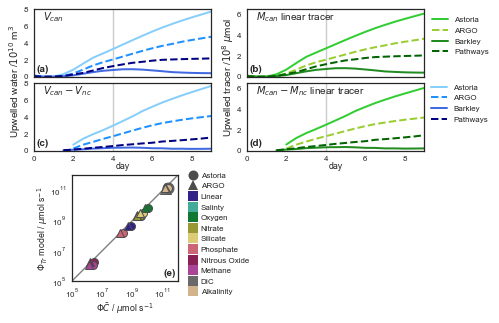

In [146]:
sns.set_style('white')
sns.set_context('paper')
plt.rcParams.update({'font.size': 11})
fig=plt.figure(figsize=(7,5))

gs = gspec.GridSpec(2, 1, hspace=0.2, wspace=0.2, height_ratios=[2,1.5])
gs0 = gspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0],hspace=0.1, wspace=0.2)
gs1 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1],hspace=0.1, wspace=0.15)

ax0 = plt.subplot(gs0[0,0],xticks=[])
ax1 = plt.subplot(gs0[0,1],xticks=[])
ax2 = plt.subplot(gs0[1,0])
ax3 = plt.subplot(gs0[1,1])
ax4 = plt.subplot(gs1[0])
#ax5 = plt.subplot(gs1[1])

colors_water = ['lightskyblue','dodgerblue', 'royalblue','navy']
colors_tracer = ['limegreen','yellowgreen','forestgreen','darkgreen']
    
for ax in [ax0,ax1,ax2,ax3]:
    ax.set_xlim(0,9)
    ax.axvline(4,color='0.8')

#------- Plot linear tracer time series of HCW and Tr Mass--------------------------------------------------------
key = 'Tr01'

f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
df_Ast = pd.read_csv(f_Ast)
HCW_Ast = df_Ast['HCW']
TrMass_Ast = df_Ast['TrMassHCW']

f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
df_AstNoC = pd.read_csv(f_AstNoC)
HCW_AstNoC = df_AstNoC['HCW']
TrMass_AstNoC = df_AstNoC['TrMassHCW']

f_Ast3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
df_Ast3 = pd.read_csv(f_Ast3)
HCW_Ast3 = df_Ast3['HCW']
TrMass_Ast3 = df_Ast3['TrMassHCW']

f_Ast3NoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
df_Ast3NoC = pd.read_csv(f_Ast3NoC)
HCW_Ast3NoC = df_Ast3NoC['HCW']
TrMass_Ast3NoC = df_Ast3NoC['TrMassHCW']


f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
df_Bar = pd.read_csv(f_Bar)
HCW_Bar = df_Bar['HCW']
TrMass_Bar = df_Bar['TrMassHCW']

f_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
df_BarNoC = pd.read_csv(f_BarNoC)
HCW_BarNoC = df_BarNoC['HCW']
TrMass_BarNoC = df_BarNoC['TrMassHCW']

f_Bar3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
df_Bar3 = pd.read_csv(f_Bar3)
HCW_Bar3 = df_Bar3['HCW']
TrMass_Bar3 = df_Bar3['TrMassHCW']

f_Bar3NoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
df_Bar3NoC = pd.read_csv(f_Bar3NoC)
HCW_Bar3NoC = df_Bar3NoC['HCW']
TrMass_Bar3NoC = df_Bar3NoC['TrMassHCW']


ax0.plot(np.arange(19)/2, HCW_Ast/1E10, color=colors_water[0], linewidth=2, label='Astoria')
ax0.plot(np.arange(19)/2, HCW_Ast3/1E10,'--', color=colors_water[1],linewidth=2, label='ARGO')
ax0.plot(np.arange(19)/2, HCW_Bar/1E10, color=colors_water[2],  linewidth=2, label='Barkley')
ax0.plot(np.arange(19)/2, HCW_Bar3/1E10,'--', color=colors_water[3],linewidth=2, label='Pathways')

ax1.plot(np.arange(19)/2, TrMass_Ast*1E-3/1E8, color=colors_tracer[0], label='Astoria', linewidth=2) #*1E-3 to convert 1L to m^3
ax1.plot(np.arange(19)/2, TrMass_Ast3*1E-3/1E8,'--', color=colors_tracer[1], label='ARGO', linewidth=2)
ax1.plot(np.arange(19)/2, TrMass_Bar*1E-3/1E8, color=colors_tracer[2], label='Barkley', linewidth=2)
ax1.plot(np.arange(19)/2, TrMass_Bar3*1E-3/1E8,'--', color=colors_tracer[3],linewidth=2,label='Pathways')

ax2.plot(np.arange(19)/2, (HCW_Ast-HCW_AstNoC)/1E10, color=colors_water[0], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Ast3-HCW_Ast3NoC)/1E10,'--', color=colors_water[1], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Bar-HCW_BarNoC)/1E10, color=colors_water[2], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Bar3-HCW_Bar3NoC)/1E10,'--', color=colors_water[3],linewidth=2,)

ax3.plot(np.arange(19)/2, (TrMass_Ast-TrMass_AstNoC)*1E-3/1E8, color=colors_tracer[0],linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Ast3-TrMass_Ast3NoC)*1E-3/1E8,'--', color=colors_tracer[1],  linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Bar-TrMass_BarNoC)*1E-3/1E8, color=colors_tracer[2],linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Bar3-TrMass_Bar3NoC)*1E-3/1E8,'--', color=colors_tracer[3],linewidth=2,)

   
ax0.text(-0.15,0.6,'Upwelled water /$10^{10}$ m$^3$',fontsize=10,  transform=ax0.transAxes, rotation=90)
ax1.text(-0.15,0.7,'Upwelled tracer /$10^{8}$ $\mu$mol',fontsize=10,  transform=ax1.transAxes, rotation=90)
ax0.text(0.05,0.85,'$V_{can}$',fontsize=10,  transform=ax0.transAxes)
ax2.text(0.05,0.85,'$V_{can}-V_{nc}$',fontsize=10,  transform=ax2.transAxes)
ax1.text(0.05,0.85,'$M_{can}$ linear tracer',fontsize=10,  transform=ax1.transAxes)
ax3.text(0.05,0.85,'$M_{can}-M_{nc}$ linear tracer',fontsize=10,  transform=ax3.transAxes)

ax2.set_xlabel('day', labelpad=0)
ax3.set_xlabel('day', labelpad=0)
ax0.set_ylim(0,8)
ax2.set_ylim(0,8)
ax1.set_ylim(0,6.5)
ax3.set_ylim(0,6.5)
ax1.legend(bbox_to_anchor=(1,1))
ax0.legend(bbox_to_anchor=(2.6,0))

#------- Plot Phi_Tr vs upwelling estimate*Cs --------------------------------------------------------

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear','Salinty','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane',
         'DIC', 'Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']

markers=['o','^']

g = 9.81 # accel. gravity
Hs = 150 # Shelf break depth
s = 0.00230 # shelf slope 
N = 0.00880 # Initial at 152.5 m
f = np.array([1.0E-4,1.05E-4])
U = 0.3
Wiso = 8900
L = 21800

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

for run, ff , mark in zip(['01','03'],f,markers):
    for key, lab, col, Csb in zip(tracers, labels, colours, sb_conc_A):
        file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_%s.csv' %(key, run))
        df = pd.read_csv(file)
        TrMass = df['TrMassHCW']

        if (key == 'Tr07' or key == 'Tr08'):
            TrMass = 1E-3*df['TrMassHCW'][:] # nMm^3 to muMm^3 and muMm^3 to mumol

        else:
            TrMass = df['TrMassHCW'][:]

        PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        Se = SE(s, N, ff, F(Ro(U,ff,Wiso)), Ro(U,ff,L))
        HA2013=((slope*(F(Ro(U,ff,Wiso))**(3/2))*(Ro(U,ff,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(ff,L,N))
        
        if key=='Tr09':
            ax4.errorbar(PhiTr*1E3, HA2013*Csb*1E3, yerr=PhiTr_std, marker=mark, markersize=11,markerfacecolor=col, 
                         markeredgecolor='0.3', markeredgewidth=1, alpha=0.9)
        else:
            ax4.errorbar(PhiTr*1E3, HA2013*Csb*1E3, yerr=PhiTr_std, marker=mark, markersize=8,markerfacecolor=col, 
                         markeredgecolor='0.3', markeredgewidth=1)
ax4.plot(np.linspace(0,1E12,50),np.linspace(0,1E12,50),'-', color='0.5')    
ax4.set_ylim(1E5,1E12)
ax4.set_xlim(1E5,1E12)
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_aspect(1)
ax4.set_ylabel(r'$\Phi_{Tr}$ model / $\mu$mol s$^{-1}$', labelpad=0)
ax4.set_xlabel(r'$\Phi \bar{C}$ / $\mu$mol s$^{-1}$', labelpad=0)

legend_elements = [Line2D([0], [0], marker='o',color='w', label='Astoria',
                          markerfacecolor='0.3', mec='0.3',markersize=10),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='0.3', mec='0.3',markersize=10),
                   
                  ]

for ii in range(len(colours)):
    legend_elements.append(Line2D([0], [0], marker='s',color='w', label=labels[ii],
                           markerfacecolor=colours[ii], mec=colours[ii],markersize=10),)

ax4.legend(handles=legend_elements, bbox_to_anchor=(1,1.1), handletextpad=0)

ax0.text(0.015,0.07,'(a)',fontsize=10, fontweight='bold',  transform=ax0.transAxes)
ax1.text(0.015,0.07,'(b)',fontsize=10, fontweight='bold',  transform=ax1.transAxes)
ax2.text(0.015,0.07,'(c)',fontsize=10, fontweight='bold',  transform=ax2.transAxes)
ax3.text(0.015,0.07,'(d)',fontsize=10, fontweight='bold',  transform=ax3.transAxes)
ax4.text(0.87,0.05,'(e)',fontsize=10, fontweight='bold',  transform=ax4.transAxes)


plt.savefig('upwelled_water.eps',format='eps', bbox_inches='tight')

### Table Tracer on Shelf

In [107]:
labels_exp = ['Astoria', 'Ast. ARGO', 'Barkley', 'Bar. Path.']
labels_tra = ['Lin','Sal','Oxy','Nit','Sil','Pho','NiO','Met','DIC','Alk']
units = ['(muM)m3/s','PSU','(umol/kg)m3/s','(muM)m3/s','(muM)m3/s','muM)m3/s','(nM)m3/s','(nM)m3/s','(umol/kg)m3/s','(umol/kg)m3/s']


print ("\t".join(['Run and Tracer &', 
                  '$\Phi_{Tr}$/10^{6} umol/s &',
                  '$M_can$/10^{12} umol',
                  '$M_{can}-M_{nc}/M_{can}$ day 9'
                  '$\mathcal{M}$/10^{12} umol &',
                 ]))

exp_files = ['saved_calcs/pool_AST.nc',
             'saved_calcs/pool_ARGO.nc',
             'saved_calcs/pool_BAR.nc',
             'saved_calcs/pool_PATH.nc']

exp_files_BAC = ['saved_calcs/BAC_AST.nc',
                 'saved_calcs/BAC_ARGO.nc',
                 'saved_calcs/BAC_BAR.nc',
                 'saved_calcs/BAC_PATH.nc']

  
for key, tr_lab in zip(tracers,labels_tra):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    f_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
    f_Path = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    f_PathNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    
    df_Bar = pd.read_csv(f_Bar)
    df_Path = pd.read_csv(f_Path)
    df_BarNoC = pd.read_csv(f_BarNoC)
    df_PathNoC = pd.read_csv(f_PathNoC)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW'][:]/1E-3 # nMm^3 to muMm^3 and muMm^3 to mumol
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW'][:]/1E-3
        TrMass_AstNoC = 1E-3*df_AstNoC['TrMassHCW'][:]/1E-3
        TrMass_ArgoNoC = 1E-3*df_ArgoNoC['TrMassHCW'][:]/1E-3

        TotMass_Ast = 1E-3*df_Ast['TotTrMass'][:]/1E-3
        TotMass_Argo = 1E-3*df_Argo['TotTrMass'][:]/1E-3
        TotMass_AstNoC = 1E-3*df_AstNoC['TotTrMass'][:]/1E-3
        TotMass_ArgoNoC = 1E-3*df_ArgoNoC['TotTrMass'][:]/1E-3

        TrMass_Bar = 1E-3*df_Bar['TrMassHCW'][:]/1E-3
        TrMass_Path = 1E-3*df_Path['TrMassHCW'][:]/1E-3
        TrMass_BarNoC = 1E-3*df_BarNoC['TrMassHCW'][:]/1E-3
        TrMass_PathNoC = 1E-3*df_PathNoC['TrMassHCW'][:]/1E-3

        TotMass_Bar = 1E-3*df_Bar['TotTrMass'][:]/1E-3
        TotMass_Path = 1E-3*df_Path['TotTrMass'][:]/1E-3
        TotMass_BarNoC = 1E-3*df_BarNoC['TotTrMass'][:]/1E-3
        TotMass_PathNoC = 1E-3*df_PathNoC['TotTrMass'][:]/1E-3

    
    else:
        TrMass_Ast = df_Ast['TrMassHCW'][:]/1E-3
        TrMass_Argo = df_Argo['TrMassHCW'][:]/1E-3
        TrMass_AstNoC = df_AstNoC['TrMassHCW'][:]/1E-3
        TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW'][:]/1E-3

        TotMass_Ast = df_Ast['TotTrMass'][:]/1E-3
        TotMass_Argo = df_Argo['TotTrMass'][:]/1E-3
        TotMass_AstNoC = df_AstNoC['TotTrMass'][:]/1E-3
        TotMass_ArgoNoC = df_ArgoNoC['TotTrMass'][:]/1E-3

        TrMass_Bar = df_Bar['TrMassHCW'][:]/1E-3
        TrMass_Path = df_Path['TrMassHCW'][:]/1E-3
        TrMass_BarNoC = df_BarNoC['TrMassHCW'][:]/1E-3
        TrMass_PathNoC = df_PathNoC['TrMassHCW'][:]/1E-3

        TotMass_Bar = df_Bar['TotTrMass'][:]/1E-3
        TotMass_Path = df_Path['TotTrMass'][:]/1E-3
        TotMass_BarNoC = df_BarNoC['TotTrMass'][:]/1E-3
        TotMass_PathNoC = df_PathNoC['TotTrMass'][:]/1E-3
    
    PhiTr_Ast = np.mean(np.array([(TrMass_Ast[ii]-TrMass_Ast[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Ast_std = np.std(np.array([(TrMass_Ast[ii]-TrMass_Ast[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Argo = np.mean(np.array([(TrMass_Argo[ii]-TrMass_Argo[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Argo_std = np.std(np.array([(TrMass_Argo[ii]-TrMass_Argo[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Bar = np.mean(np.array([(TrMass_Bar[ii]-TrMass_Bar[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Bar_std = np.std(np.array([(TrMass_Bar[ii]-TrMass_Bar[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Path = np.mean(np.array([(TrMass_Path[ii]-TrMass_Path[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Path_std = np.std(np.array([(TrMass_Path[ii]-TrMass_Path[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
   
    print ("\t".join(['Astoria %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Ast/1E6, PhiTr_Ast_std/1E6),
                      '%1.2f &' %(TrMass_Ast[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Ast[18]-TrMass_AstNoC[18])/TrMass_Ast[18]),
                      '%1.2f skl ' %((TotMass_Ast[18]-TotMass_AstNoC[18])/1E12),
                     ]))
    print ("\t".join(['Ast. ARGO %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Argo/1E6, PhiTr_Argo_std/1E6),
                      '%1.2f &' %(TrMass_Argo[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Argo[18]-TrMass_ArgoNoC[18])/TrMass_Argo[18]),
                      '%1.2f skl ' %((TotMass_Argo[18]-TotMass_ArgoNoC[18])/1E12),
                     ]))
    print ("\t".join(['Barkley %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Bar/1E6, PhiTr_Bar_std/1E6),
                      '%1.2f &' %(TrMass_Bar[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Bar[18]-TrMass_BarNoC[18])/TrMass_Bar[18]),
                      '%1.2f skl ' %((TotMass_Bar[18]-TotMass_BarNoC[18])/1E12),
                     ]))
    print ("\t".join(['Bar. Path. %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Path/1E6,PhiTr_Path_std/1E6),
                      '%1.2f &' %(TrMass_Path[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Path[18]-TrMass_PathNoC[18])/TrMass_Path[18]),
                      '%1.2f skl ' %((TotMass_Path[18]-TotMass_PathNoC[18])/1E12),
                     ]))
   

Run and Tracer &	$\Phi_{Tr}$/10^{6} umol/s &	$M_can$/10^{12} umol	$M_{can}-M_{nc}/M_{can}$ day 9$\mathcal{M}$/10^{12} umol &
Astoria Lin &	814.88$\pm$127.08 &	611.07 &	99.38 &	212.65 skl 
Ast. ARGO Lin &	493.39$\pm$93.71 &	367.43 &	87.29 &	106.97 skl 
Barkley Lin &	-59.39$\pm$141.97 &	39.16 &	56.27 &	16.04 skl 
Bar. Path. Lin &	238.58$\pm$157.01 &	205.89 &	72.68 &	31.98 skl 
Astoria Sal &	3633.74$\pm$508.47 &	2626.40 &	99.33 &	19.77 skl 
Ast. ARGO Sal &	2224.57$\pm$422.54 &	1611.29 &	86.70 &	9.77 skl 
Barkley Sal &	-213.87$\pm$533.20 &	142.02 &	55.44 &	0.99 skl 
Bar. Path. Sal &	876.23$\pm$574.04 &	739.97 &	71.90 &	1.49 skl 
Astoria Oxy &	11219.86$\pm$1432.25 &	7854.01 &	99.30 &	-2564.56 skl 
Ast. ARGO Oxy &	6845.62$\pm$1284.41 &	4834.42 &	86.48 &	-1298.71 skl 
Barkley Oxy &	-513.92$\pm$1384.88 &	362.55 &	55.13 &	-161.16 skl 
Bar. Path. Oxy &	2298.77$\pm$1453.81 &	1881.51 &	71.38 &	-282.37 skl 
Astoria Nit &	3516.32$\pm$507.94 &	2569.72 &	99.34 &	355.22 skl 
Ast. ARGO Nit &	2152.17$\pm